# The sample codes for running RGD tomography

## define the functions

In [1]:
import numpy as np
import RGD
from BasicTools import Plt_Err_Time

from functools import reduce

from qibo.models.encodings import ghz_state
from qibo.hamiltonians import SymbolicHamiltonian
from qibochem.measurement import expectation


from qibo.symbols import I, X, Y, Z

symbol_map = {
    "X": X,
    "Y": Y,
    "Z": Z,
    "I": I,
}

def generate_random_label(n, symbols=["I", "X", "Y", "Z"]):
    num_symbols = len(symbols)
    label = "".join([symbols[i] for i in np.random.randint(0, num_symbols, size=n)])
    return label

## choose the Pauli string (operator) for doing tomography

In [2]:
num_labels = 5      #  number of Pauli labels
n = 3               #  number of qubits
# labels = [generate_random_label(n) for i in range(num_labels)]

labels = ["YXY", "IXX", "ZYI", "XXX", "YZZ", "ZYY", "IXX", "XYY", "XZI"]
# labels = ['YZY', 'YYZ', 'XIY', 'IZY', 'YYY','XZI','IXZ','IIY','XXY','YZZ']
# labels = ['XXYY', 'YXZY', 'XZIZ', 'ZYYZ', 'YXYX', 'ZXXZ', 'ZIYZ', 'YXYY', 'YXYY', 'ZYYY']
# labels = ['ZIYZ', 'YXZX', 'ZIXX', 'YXYX', 'ZYXX']
# labels = ['IZZ', 'IIZ','ZIZ']    # NotImplementedError: Observable is not a Z Pauli string.


## generate circuit & shot measurements

In [3]:
Nr = 1                                          #  rank of the target density matrix

stateGHZ = ghz_state(n)                         # generate GHZ state circuit
target_state_GHZ = stateGHZ.execute().state()   # get the state vector of the circuit
target_density_matrix = np.outer(target_state_GHZ, target_state_GHZ.conj())

num_shots = 200                                 # number of shot measurements

[Qibo 0.2.17|INFO|2025-07-28 23:08:52]: Using qibojit (numba) backend on /CPU:0


In [4]:
Proj_list = []
coef_exact = []
coef_shots = []
for label in labels:
    # print(f"label = {label}")

    qubitPauli = [symbol_map[Ps](i) for i, Ps in enumerate(label)]
    symbolPauli = SymbolicHamiltonian(reduce(lambda x, y: x * y, qubitPauli))

    _circuit = stateGHZ.copy()

    coef_Pauli_exact = expectation(_circuit, symbolPauli)
    if label == "III":
        coef_Pauli_shots = 1.0
    else:
        coef_Pauli_shots = symbolPauli.expectation_from_circuit(_circuit, nshots=num_shots)

    Proj_list.append(symbolPauli)
    coef_exact.append(coef_Pauli_exact)
    coef_shots.append(coef_Pauli_shots.real)


## system parameters as the input to the RGD worker

In [5]:
params_dict = {
    "Nr": Nr,
    "target_DM": target_density_matrix,
    "labels": labels,
    "measurement_list": coef_shots, #measurement_list,
    "symProj_list": Proj_list, #symProj_list,
    # "num_iterations": 150,
    "convergence_check_period": 1,
}

Ch_svd = -1  #   choice for initial SVD  (0: LA.svd, 1: svds, -1: rSVD)
InitX_RGD = 1  #   method of choosing initial X0

## running the RGD once collecting the input information

In [6]:
worker = RGD.BasicWorkerRGD(params_dict)
worker.computeRGD(InitX_RGD, Ch_svd)

[Qibo 0.2.17|WARNING|2025-07-28 23:09:58]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.17|WARNING|2025-07-28 23:09:58]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.17|WARNING|2025-07-28 23:09:58]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.17|WARNING|2025-07-28 23:09:58]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.17|WARNING|2025-07-28 23:09:58]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.17|WARNING|2025-07-28 23:09:58]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.17|WARNING|2025-07-28 23:09:58]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.17|WARNING|2025-07-28 23:09:58]: Calculating 

num_iterations = 150
  self.coef = 0.9428090415820634
  InitX     = 1
 *********   using randomized-SVD  to construct  X0 = uk @ sDiag @ vkh  **************************
  ***   0-th (A A*) done:   Time --> ATQ: 6.198883056640625e-05,  AG: 5.698204040527344e-05   ***
  ***   1-th (A A*) done:   Time --> ATQ: 4.9114227294921875e-05,  AG: 4.506111145019531e-05   ***
  ***   2-th (A A*) done:   Time --> ATQ: 4.315376281738281e-05,  AG: 4.1961669921875e-05   ***
  ***   3-th (A A*) done:   Time --> ATQ: 5.316734313964844e-05,  AG: 4.363059997558594e-05   ***
  ***   4-th (A A*) done:   Time --> ATQ: 4.291534423828125e-05,  AG: 4.00543212890625e-05   ***
  ***   5-th (A A*) done:   Time --> ATQ: 4.100799560546875e-05,  AG: 4.00543212890625e-05   ***
  ***   6-th (A A*) done:   Time --> ATQ: 3.886222839355469e-05,  AG: 3.910064697265625e-05   ***
  ***   7-th (A A*) done:   Time --> ATQ: 4.100799560546875e-05,  AG: 4.00543212890625e-05   ***
  ***   8-th (A A*) done:   Time --> ATQ: 3.9815902

## plot the error and time evolution of the RGD algorithm

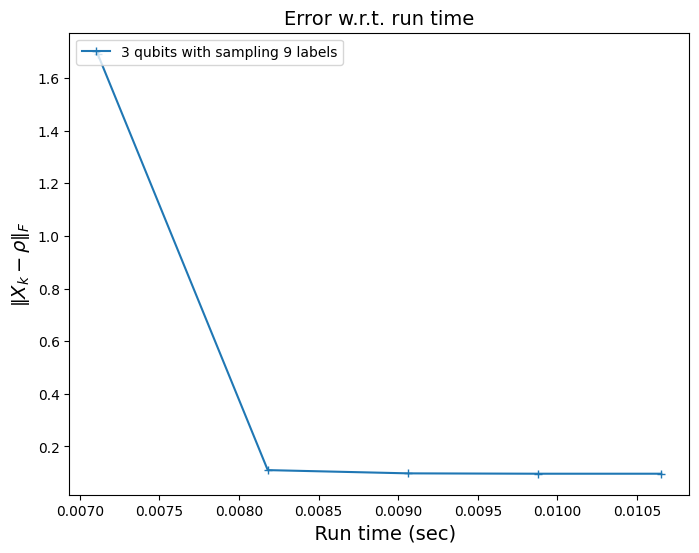

In [7]:
Plt_Err_Time(worker)    # plot the error and time evolution of the RGD algorithm
